In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import math


/var/folders/bp/zbbdn_091x1_34h2k7b9nszm0000gn/T/ipykernel_57700/2806099818.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# colourblind-friendly palette from colour universal design (CUD)
# https://jfly.uni-koeln.de/color/
# https://nanx.me/oneclust/reference/cud.html
named_colors = {
    "black": "#000000",
    "orange": "#e69f00",
    "skyblue": "#56b4e9",
    "bluish green": "#009e73",
    "yellow": "#f0e442",
    "blue": "#0072b2",
    "vermilion": "#d55e00",
    "reddish purple": "#cc79a7",
}
cud_palette = list(named_colors.values())
sns.set_theme(style="whitegrid")

def cud(n: int = len(cud_palette), start: int = 0) -> list[str]:
    remainder = cud_palette[:start]
    palette = cud_palette[start:] + remainder
    return palette[:n]

In [3]:
# read in the QC files to get full depth of each sample
frames = []
for p in Path("../results/QC/stats/postfilter").rglob("*.csv"):
    df = pd.read_csv(p)
    df["model"] = df["model"].apply(lambda x: x.split("_")[-1].split("@")[0])
    # rename filename column to sample and mean_coverage to depth
    df = df.rename(columns={"filename": "sample", "mean_coverage": "depth"})
    df["mode"] = p.parts[-3]
    frames.append(df)

In [4]:
depth_df = pd.concat(frames)
depth_df.set_index(["sample", "mode", "model"], inplace=True, verify_integrity=True)
depth_df.head()

,,,num_alignments,percent_total_reads,yield_gb,depth,yield_gb_gt_25kb,n50,n75,median_length,mean_length,median_identity,mean_identity
sample,mode,model,,,,,,,,,,,
AJ292__202310,duplex,hac,3428,98.45,0.02,6.87,0.02,21381,9766,5738.5,10905.0,99.79,99.57
AMtb_1__202402,duplex,hac,6675,99.70,0.00,7.06,0.00,5844,3922,4135.0,4662.0,99.51,99.11
ATCC_10708__202309,duplex,hac,86304,99.86,0.01,58.34,0.01,4516,2221,1992.0,3245.0,99.79,99.60
ATCC_17802__202309,duplex,hac,34647,99.43,0.01,23.90,0.01,5102,2506,2146.0,3550.0,99.81,99.63
ATCC_19119__202309,duplex,hac,24431,99.13,0.01,42.64,0.01,8580,3960,2942.0,5095.0,99.83,99.64


In [5]:
DUPLEX_DP_CAP = 50
illumina_frames = []
frames = []
for p in Path("../results/assess/mutref").rglob("*.precision-recall.tsv"):
    df = pd.read_csv(p, sep="\t")
    sample = p.parent.name
    df["sample"] = sample
    if "without_repetitive_regions" in p.name:
        df["mask_repeats"] = True
    else:
        df["mask_repeats"] = False
    if "illumina" in str(p):
        df["caller"] = "illumina"
        illumina_frames.append(df)
        continue
    else:
        df["caller"] = p.parts[-7]
        dp = int(p.parts[-6][:-1])
        mode = p.parts[-5]
        model = p.parts[-3].split("_")[-1].split("@")[0]
        full_dp = depth_df.loc[(sample, mode, model), "depth"]
        if full_dp < (dp * 0.9):
            print(f"Skipping {sample} {mode} {model} {full_dp} < {dp}")
            continue
        if mode == "duplex" and model == "fast":
            continue
        if mode == "duplex" and dp > DUPLEX_DP_CAP:
            continue
        df["depth"] = dp
        df["mode"] = mode
        df["version"] = p.parts[-4]
        df["model"] = model
    frames.append(df)
    # duplicate Illumina as duplex also
    if "illumina" in str(p):
        continue
        df2 = df.copy()
        # df2["caller"] = "illumina"
        # df2["depth"] = 100
        # df2["mode"] = "duplex"
        # df2["version"] = "illumina"
        # df2["model"] = "illumina"
        # frames.append(df2)

Skipping AMtb_1__202402 duplex hac 7.06 < 10
Skipping AMtb_1__202402 duplex hac 7.06 < 10
Skipping KPC2__202310 duplex hac 2.71 < 10
Skipping KPC2__202310 duplex hac 2.71 < 10
Skipping AJ292__202310 duplex hac 6.87 < 10
Skipping AJ292__202310 duplex hac 6.87 < 10
Skipping AMtb_1__202402 duplex sup 7.48 < 10
Skipping AMtb_1__202402 duplex sup 7.48 < 10
Skipping KPC2__202310 duplex sup 2.88 < 10
Skipping KPC2__202310 duplex sup 2.88 < 10
Skipping AJ292__202310 duplex sup 7.34 < 10
Skipping AJ292__202310 duplex sup 7.34 < 10
Skipping AMtb_1__202402 duplex fast 4.18 < 10
Skipping AMtb_1__202402 duplex fast 4.18 < 10
Skipping KPC2__202310 duplex fast 2.28 < 10
Skipping KPC2__202310 duplex fast 2.28 < 10
Skipping AJ292__202310 duplex fast 5.68 < 10
Skipping AJ292__202310 duplex fast 5.68 < 10
Skipping AMtb_1__202402 duplex hac 7.06 < 50
Skipping AMtb_1__202402 duplex hac 7.06 < 50
Skipping ATCC_25922__202309 duplex hac 34.96 < 50
Skipping ATCC_25922__202309 duplex hac 34.96 < 50
Skipping MMC

In [6]:
illumina_df = pd.concat(illumina_frames)
illumina_df.reset_index(inplace=True, drop=True)
illumina_df.head()

,VAR_TYPE,MIN_QUAL,PREC,RECALL,F1_SCORE,F1_QSCORE,TRUTH_TOTAL,TRUTH_TP,TRUTH_FN,QUERY_TOTAL,QUERY_TP,QUERY_FP,sample,mask_repeats,caller
0,SNP,0,0.951398,0.987155,0.968947,15.078963,2102,2075,27,2181,2075,106,AMtb_1__202402,False,illumina
1,SNP,1,0.957987,0.987155,0.972352,15.583424,2102,2075,27,2166,2075,91,AMtb_1__202402,False,illumina
2,SNP,2,0.959316,0.987155,0.973036,15.692213,2102,2075,27,2163,2075,88,AMtb_1__202402,False,illumina
3,SNP,3,0.960648,0.987155,0.973721,15.803946,2102,2075,27,2160,2075,85,AMtb_1__202402,False,illumina
4,SNP,4,0.962430,0.987155,0.974636,15.957815,2102,2075,27,2156,2075,81,AMtb_1__202402,False,illumina


In [7]:
pr_df = pd.concat(frames)
pr_df.reset_index(inplace=True, drop=True)
# drop all columns except thw following
keep_cols = [
    "MIN_QUAL",
    "PREC",
    "RECALL",
    "F1_SCORE",
    "VAR_TYPE",
    "sample",
    "mask_repeats",
    "caller",
    "depth",
    "mode",
    "version",
    "model",
]
pr_df = pr_df[keep_cols]
pr_df.head()

,MIN_QUAL,PREC,RECALL,F1_SCORE,VAR_TYPE,sample,mask_repeats,caller,depth,mode,version,model
0,0,0.997591,0.998072,0.997831,SNP,ATCC_35897__202309,True,nanocaller,10,duplex,v4.3.0,hac
1,1,0.997591,0.998072,0.997831,SNP,ATCC_35897__202309,True,nanocaller,10,duplex,v4.3.0,hac
2,2,0.997591,0.998072,0.997831,SNP,ATCC_35897__202309,True,nanocaller,10,duplex,v4.3.0,hac
3,3,0.997591,0.998072,0.997831,SNP,ATCC_35897__202309,True,nanocaller,10,duplex,v4.3.0,hac
4,4,0.997591,0.998072,0.997831,SNP,ATCC_35897__202309,True,nanocaller,10,duplex,v4.3.0,hac


In [8]:
x = "depth"
y = "value"
hue = "caller"
col = "model"
row = "metric"

In [9]:
best_ix = (
    pr_df.query("not mask_repeats")
    .groupby([x, hue, col, "sample", "VAR_TYPE", "mode"])["F1_SCORE"]
    .idxmax()
)
best_df = pr_df.iloc[best_ix]
best_df = best_df.melt(
    id_vars=keep_cols[4:],
    value_vars=["PREC", "RECALL", "F1_SCORE"],
    var_name="metric",
    value_name="value",
)
# rename the values to be more descriptive
best_df["metric"] = best_df["metric"].replace(
    {"PREC": "Precision", "RECALL": "Recall", "F1_SCORE": "F1 Score"}
)

In [10]:
import numpy as np
import scipy.stats

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h


In [11]:
# gather the best Illumina F1 scores for each sample and then 
# take the mean and std of F1, Recall, and Precision
ix = illumina_df.query("not mask_repeats").groupby(["sample", "VAR_TYPE"])["F1_SCORE"].idxmax()
illumina_best_df = illumina_df.iloc[ix]
illumina_best_df = illumina_best_df.melt(
    id_vars=["sample", "VAR_TYPE"],
    value_vars=["PREC", "RECALL", "F1_SCORE"],
    var_name="metric",
    value_name="value",
)
illumina_best_df["metric"] = illumina_best_df["metric"].replace(
    {"PREC": "Precision", "RECALL": "Recall", "F1_SCORE": "F1 Score"}
)
illumina_snp = illumina_best_df.query("VAR_TYPE == 'SNP'")
illumina_snp_f1 = illumina_snp.query("metric == 'F1 Score'")["value"]
illumina_snp_f1_mean, illumina_snp_f1_low, illumina_snp_f1_high = mean_confidence_interval(illumina_snp_f1)
illumina_snp_recall = illumina_snp.query("metric == 'Recall'")["value"]
illumina_snp_recall_mean, illumina_snp_recall_low, illumina_snp_recall_high = mean_confidence_interval(illumina_snp_recall)
illumina_snp_precision = illumina_snp.query("metric == 'Precision'")["value"]
illumina_snp_precision_mean, illumina_snp_precision_low, illumina_snp_precision_high = mean_confidence_interval(illumina_snp_precision)
illumina_indel = illumina_best_df.query("VAR_TYPE == 'INDEL'")
illumina_indel_f1 = illumina_indel.query("metric == 'F1 Score'")["value"]
illumina_indel_f1_mean, illumina_indel_f1_low, illumina_indel_f1_high = mean_confidence_interval(illumina_indel_f1)
illumina_indel_recall = illumina_indel.query("metric == 'Recall'")["value"]
illumina_indel_recall_mean, illumina_indel_recall_low, illumina_indel_recall_high = mean_confidence_interval(illumina_indel_recall)
illumina_indel_precision = illumina_indel.query("metric == 'Precision'")["value"]
illumina_indel_precision_mean, illumina_indel_precision_low, illumina_indel_precision_high = mean_confidence_interval(illumina_indel_precision)
illumina = {
    "SNP": {
        "F1 Score": (illumina_snp_f1_mean, illumina_snp_f1_low, illumina_snp_f1_high),
        "Recall": (illumina_snp_recall_mean, illumina_snp_recall_low, illumina_snp_recall_high),
        "Precision": (illumina_snp_precision_mean, illumina_snp_precision_low, illumina_snp_precision_high),
    },
    "INDEL": {
        "F1 Score": (illumina_indel_f1_mean, illumina_indel_f1_low, illumina_indel_f1_high),
        "Recall": (illumina_indel_recall_mean, illumina_indel_recall_low, illumina_indel_recall_high),
        "Precision": (illumina_indel_precision_mean, illumina_indel_precision_low, illumina_indel_precision_high),
    },
}

In [15]:
hue_order = sorted(pr_df["caller"].unique())
# move longshot to the end
hue_order.remove("longshot")
hue_order.append("longshot")
bbox = (0.52, 0.72)

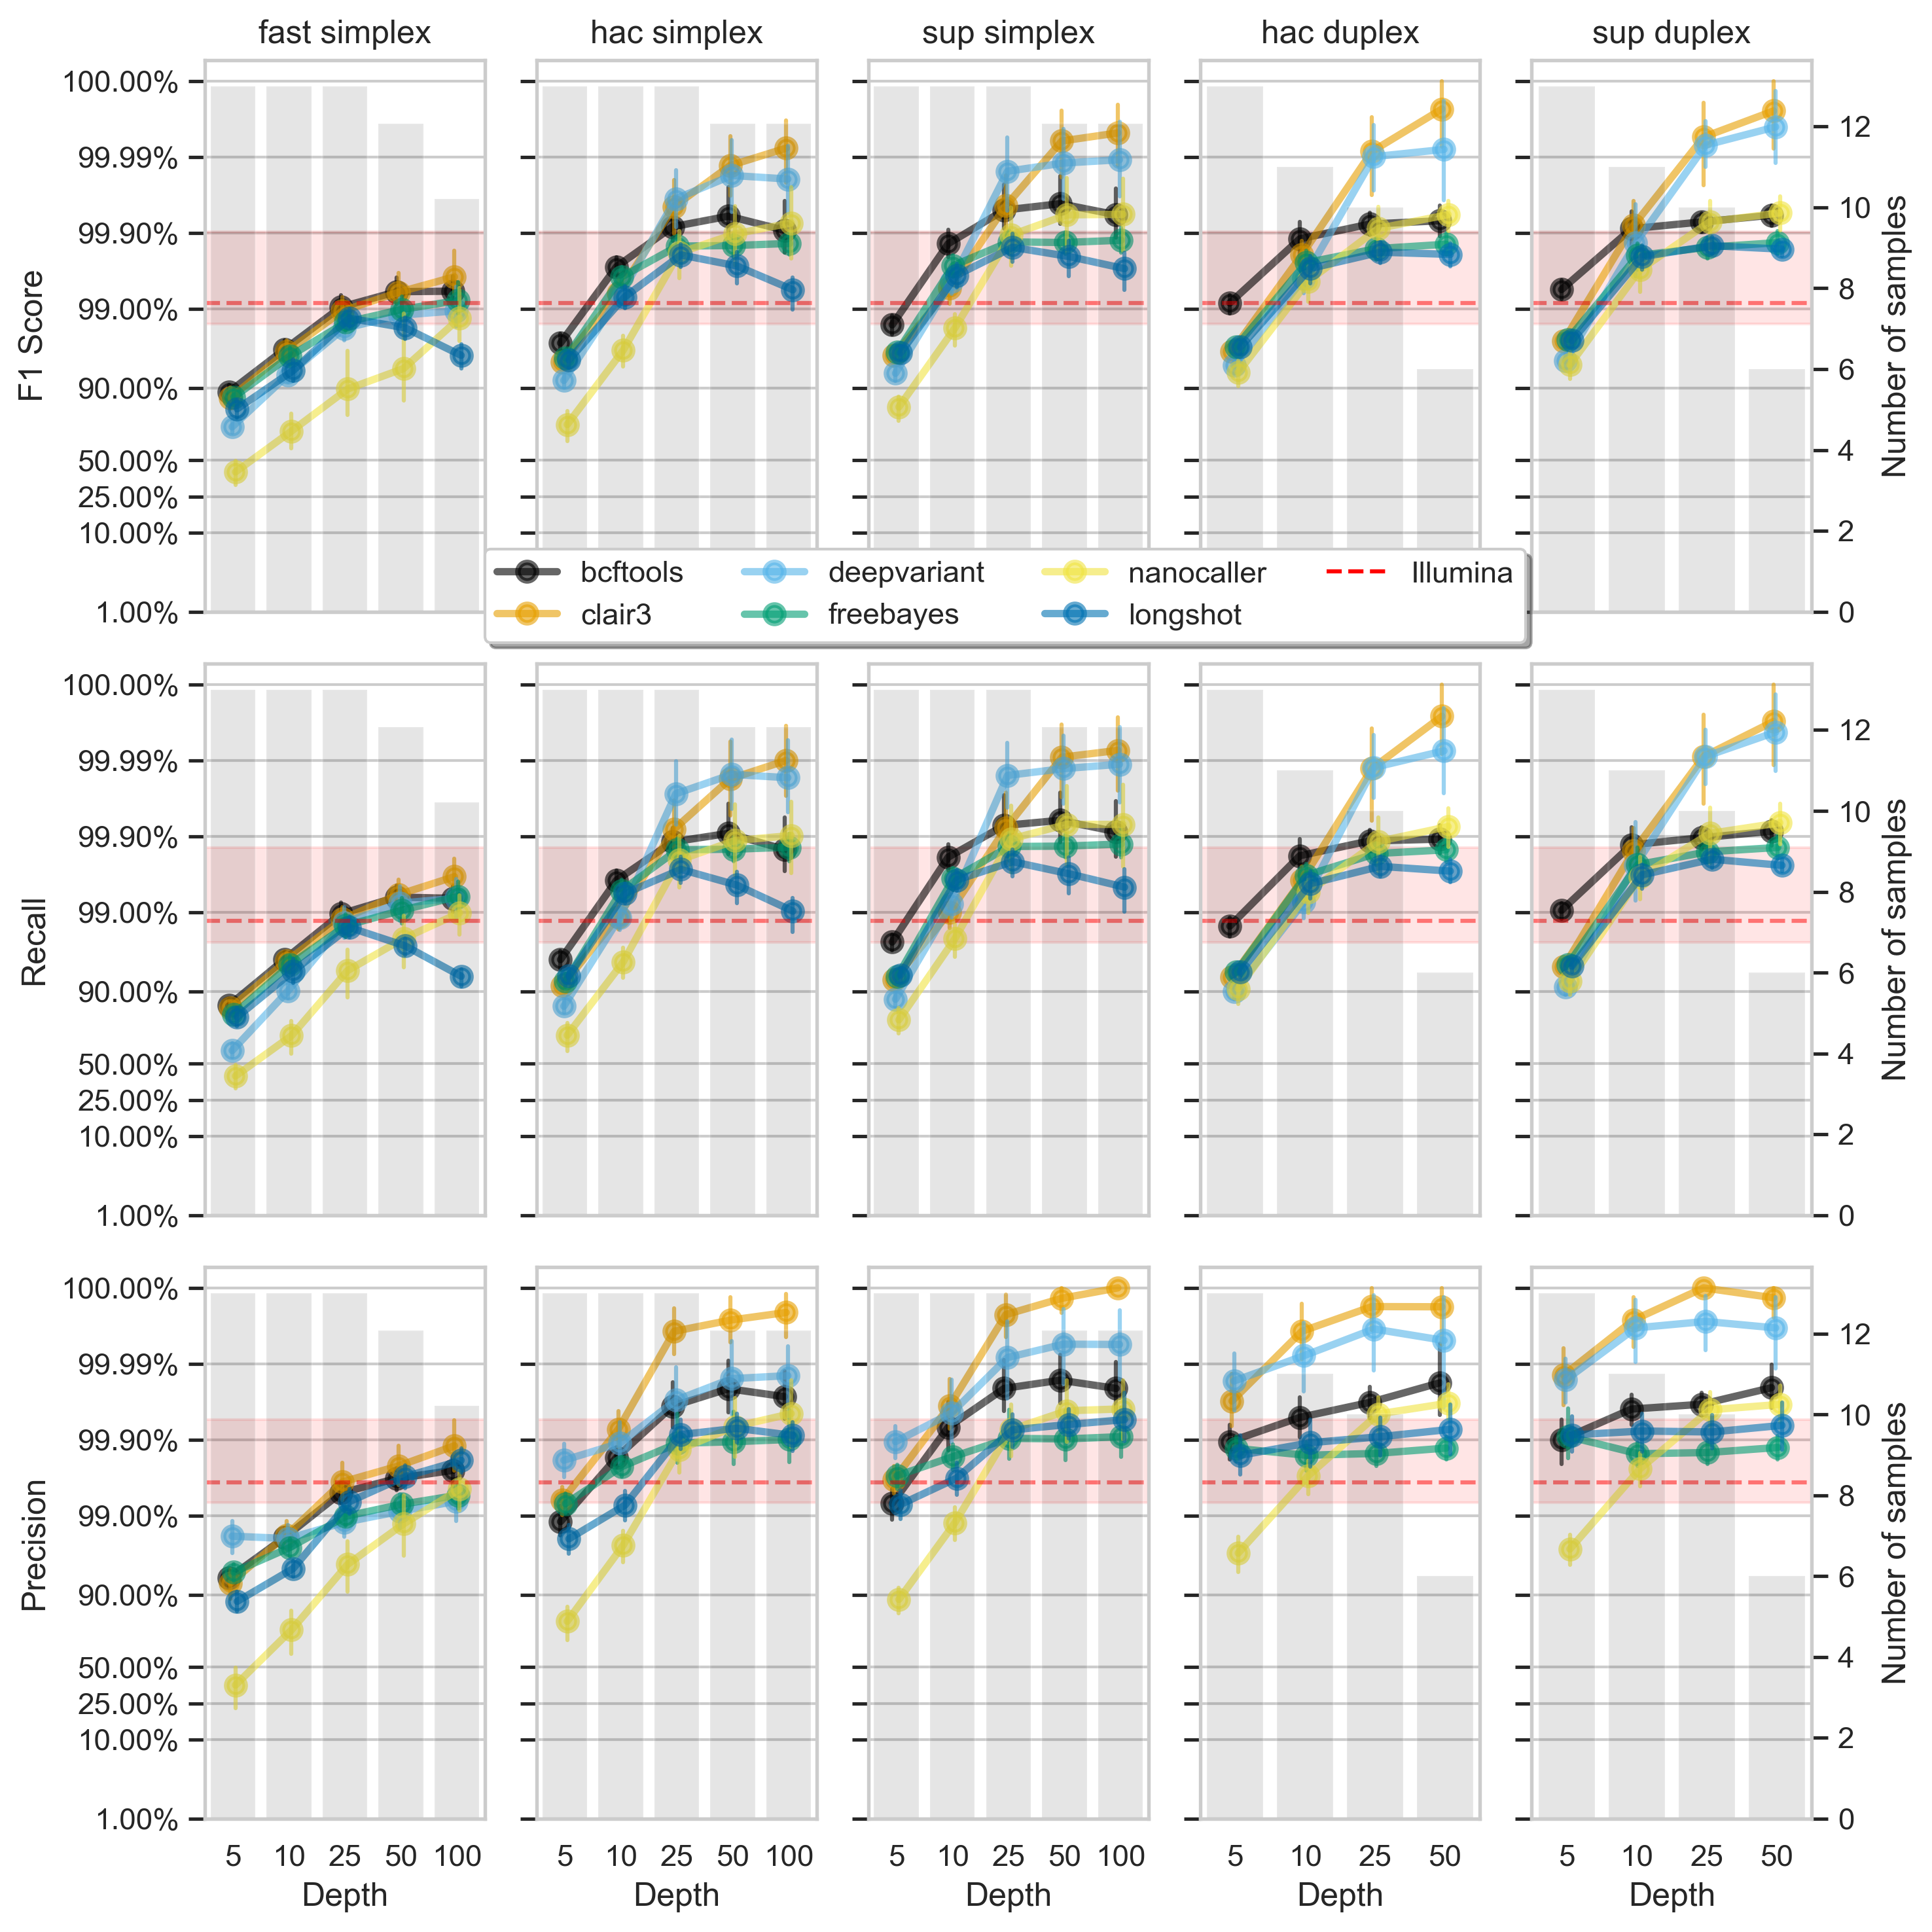

In [16]:
vartype = "SNP"
data = best_df.query(f"VAR_TYPE == '{vartype}'")
palette = cud(n=len(data[hue].unique()))
# palette = "colorblind"
row_order = ["F1 Score", "Recall", "Precision"]
ncols = len(data.query("mode == 'simplex'")[col].unique()) + len(data.query("mode == 'duplex'")[col].unique())
nrows = len(row_order)
fig, axes = plt.subplots(
    nrows=nrows, ncols=ncols, figsize=(10, 10), dpi=300, sharey=True, sharex=False
)
ill_colour = "red"
legend = True
i = 0
for metric in row_order:
    ill_mean, ill_ci_low, ill_ci_high = illumina[vartype][metric]
    for mode in ["simplex", "duplex"]:
        for model in data[col].unique():
            if model == "fast" and mode == "duplex":
                continue
            d = data.query(f"{col} == '{model}' and metric == '{metric}' and mode == '{mode}'")
            # transform precision so logit shows values of 1.0 - i.e. change values of 1.0 to 0.99999
            cap = 0.99999
            d.loc[:,y] = d[y].apply(lambda v: cap if v == 1.0 else v)
            ax = axes.flatten()[i]
            sns.pointplot(
                ax=ax,
                data=d,
                x=x,
                y=y,
                hue=hue,
                palette=palette,
                units="sample",
                dodge=True,
                legend=legend,
                alpha=0.6,
                err_kws={"linewidth": 1.5, "alpha": 0.6},
                hue_order=hue_order,
            )

            # add horizontal line for Illumina with fill_between for Std
            ax.axhline(ill_mean, color=ill_colour, linestyle="--", alpha=0.5)
            # get the x-axis limits
            xlim = ax.get_xlim()
            ax.fill_between(
                x=xlim,
                y1=ill_ci_low,
                y2=ill_ci_high,
                color=ill_colour,
                alpha=0.1,
            )

            if i < ncols:
                ax.set_title(f"{model} {mode}")

            if i < ncols * 2:
                # remove x-axis labels and ticks
                ax.set(xlabel="", xticklabels=[])
            else:
                ax.set_xlabel("Depth")

            ax.set_ylabel(metric)

            ax.set_yscale("logit", nonpositive="clip")
            yticks = [0.01, 0.1, 0.25, 0.5, 0.9, 0.99, 0.999, 0.9999, cap]
            yticklabels = [f"{yval:.2%}" for yval in yticks]
            ax.set_yticks(yticks)
            ax.set_yticklabels(yticklabels)
            if legend:
                handles, labels = ax.get_legend_handles_labels()
                # add Illumina to legend
                handles.append(plt.Line2D([0], [0], color=ill_colour, linestyle="--"))
                labels.append("Illumina")
                legend = False
                ax.legend().remove()

            # plot the number of sample at each depth
            ax2 = ax.twinx()
            xs = []
            ys = []
            for depth in d[x].unique():
                count = d.query(f"{x} == {depth}")["sample"].nunique()
                xs.append(depth)
                ys.append(count)

            sns.barplot(x=xs, y=ys, ax=ax2, color="black", alpha=0.1)
            ax2.grid(False)
            if (i + 1) % ncols == 0:
                ax2.set_ylabel("Number of samples")
            else:
                ax2.set(yticks=[], ylabel="", yticklabels=[])

            # get rid of all minor y-axis ticks
            ax.yaxis.set_minor_locator(plt.NullLocator())
            i += 1

plt.tight_layout()
leg_cols = math.ceil((len(data[hue].unique())+1)/2)
fig.legend(
    handles=handles,
    labels=labels,
    loc="upper center",
    bbox_to_anchor=bbox,
    ncol=leg_cols,
    title="",
    framealpha=1.0,
    fancybox=True,
    shadow=True,
)

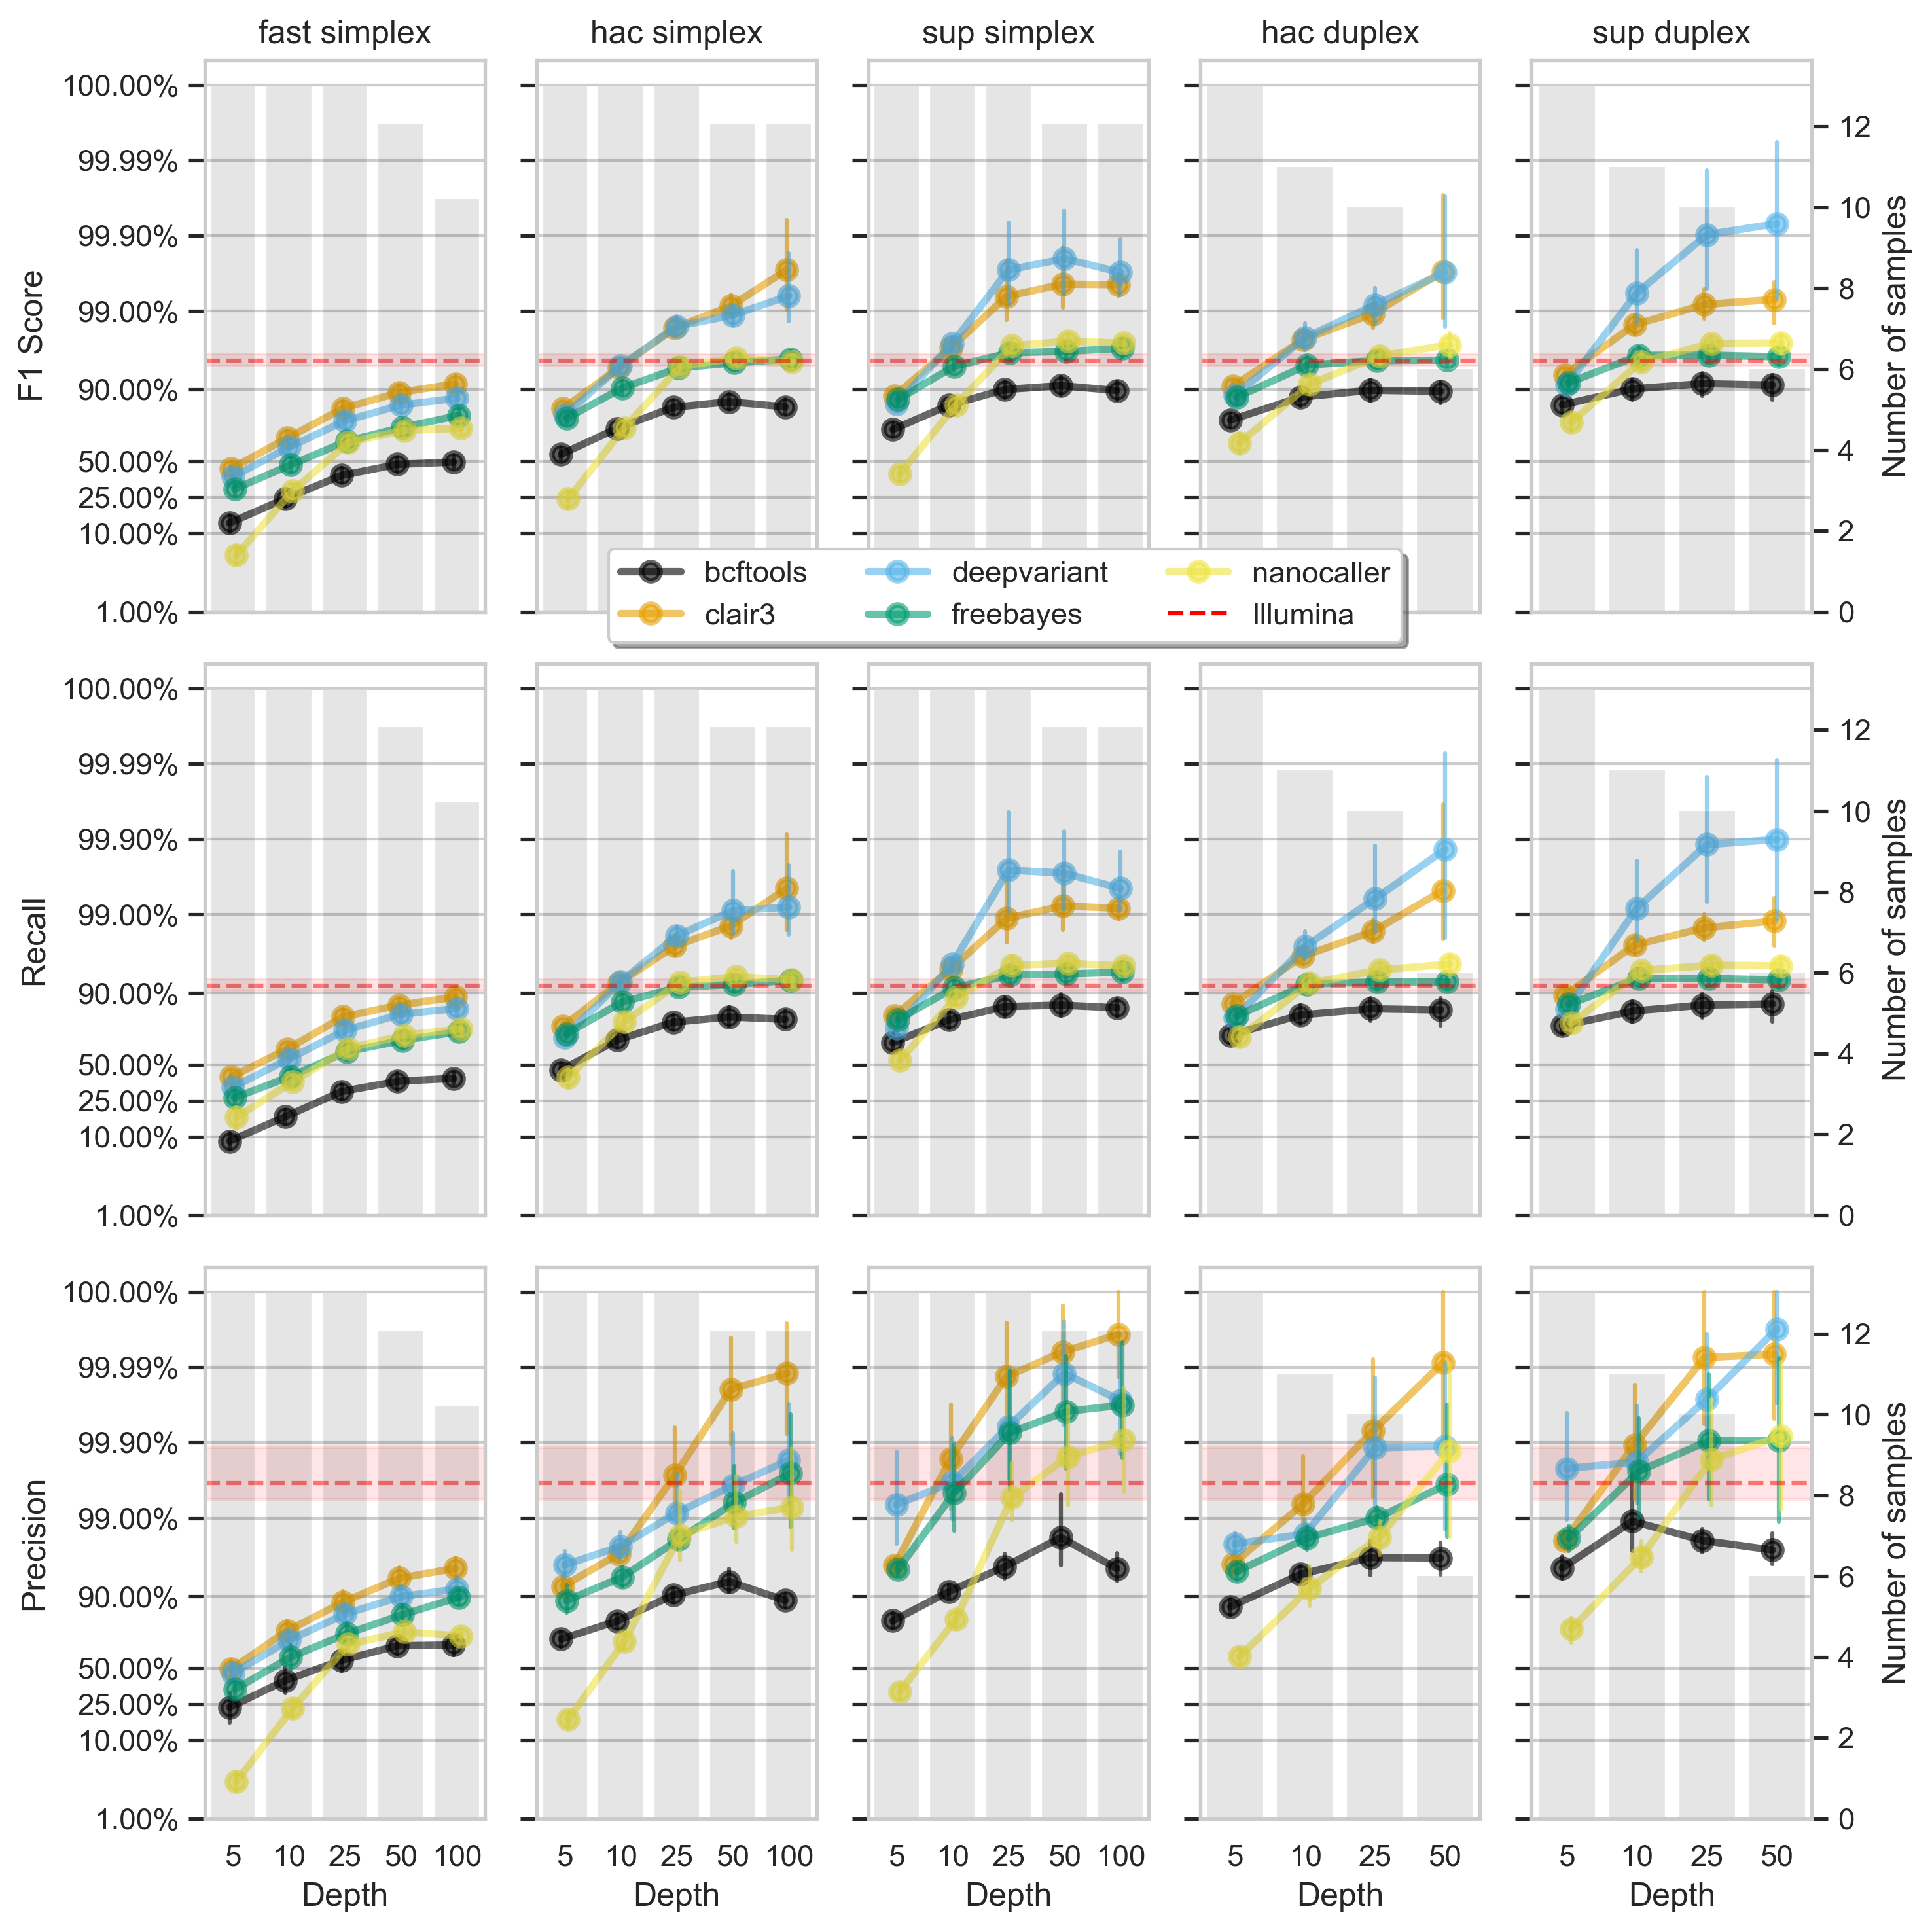

In [17]:
vartype = "INDEL"
data = best_df.query(f"VAR_TYPE == '{vartype}' and caller != 'longshot'")
hue_order = sorted(data[hue].unique())
palette = cud(n=len(data[hue].unique()))
# palette = "colorblind"
row_order = ["F1 Score", "Recall", "Precision"]
ncols = len(data.query("mode == 'simplex'")[col].unique()) + len(data.query("mode == 'duplex'")[col].unique())
nrows = len(row_order)
fig, axes = plt.subplots(
    nrows=nrows, ncols=ncols, figsize=(10, 10), dpi=300, sharey=True, sharex=False
)
ill_colour = "red"
legend = True
i = 0
for metric in row_order:
    ill_mean, ill_ci_low, ill_ci_high = illumina[vartype][metric]
    for mode in ["simplex", "duplex"]:
        for model in data[col].unique():
            if model == "fast" and mode == "duplex":
                continue
            d = data.query(f"{col} == '{model}' and metric == '{metric}' and mode == '{mode}'")
            # transform precision so logit shows values of 1.0 - i.e. change values of 1.0 to 0.99999
            cap = 0.99999
            d.loc[:,y] = d[y].apply(lambda v: cap if v == 1.0 else v)
            ax = axes.flatten()[i]
            sns.pointplot(
                ax=ax,
                data=d,
                x=x,
                y=y,
                hue=hue,
                palette=palette,
                units="sample",
                dodge=True,
                legend=legend,
                hue_order=hue_order,
                alpha=0.6,
                err_kws={"linewidth": 1.5, "alpha": 0.6},
            )

            # add horizontal line for Illumina with fill_between for Std
            ax.axhline(ill_mean, color=ill_colour, linestyle="--", alpha=0.5)
            # get the x-axis limits
            xlim = ax.get_xlim()
            ax.fill_between(
                x=xlim,
                y1=ill_ci_low,
                y2=ill_ci_high,
                color=ill_colour,
                alpha=0.1,
            )

            if i < ncols:
                ax.set_title(f"{model} {mode}")

            if i < ncols * 2:
                # remove x-axis labels and ticks
                ax.set(xlabel="", xticklabels=[])
            else:
                ax.set_xlabel("Depth")

            ax.set_ylabel(metric)

            ax.set_yscale("logit", nonpositive="clip")

            ax.set_yticks(yticks)
            ax.set_yticklabels(yticklabels)
            if legend:
                handles, labels = ax.get_legend_handles_labels()
                # add Illumina to legend
                handles.append(plt.Line2D([0], [0], color=ill_colour, linestyle="--"))
                labels.append("Illumina")
                legend = False
                ax.legend().remove()

            # plot the number of sample at each depth
            ax2 = ax.twinx()
            xs = []
            ys = []
            for depth in d[x].unique():
                count = d.query(f"{x} == {depth}")["sample"].nunique()
                xs.append(depth)
                ys.append(count)

            sns.barplot(x=xs, y=ys, ax=ax2, color="black", alpha=0.1)
            ax2.grid(False)
            if (i + 1) % ncols == 0:
                ax2.set_ylabel("Number of samples")
            else:
                ax2.set(yticks=[], ylabel="", yticklabels=[])

            # get rid of all minor y-axis ticks
            ax.yaxis.set_minor_locator(plt.NullLocator())
            i += 1

plt.tight_layout()
leg_cols = math.ceil((len(data[hue].unique())+1)/2)
fig.legend(
    handles=handles,
    labels=labels,
    loc="upper center",
    bbox_to_anchor=bbox,
    ncol=leg_cols,
    title="",
    framealpha=1.0,
    fancybox=True,
    shadow=True,
)

In [22]:
fig.savefig("indel_depth.pdf")